In [360]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
data = pd.read_csv("homework_1.1.csv")
X = data[['X1', 'X2', 'X3']]
y = data['Y']
model = LinearRegression().fit(X, y)
coef_multi = pd.Series(model.coef_, index=['X1','X2','X3'])
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)


Intercept: 0.0026430033841688405
Coefficients: [1.00713766 1.96456859 2.97548854]


Text(0, 0.5, 'Y')

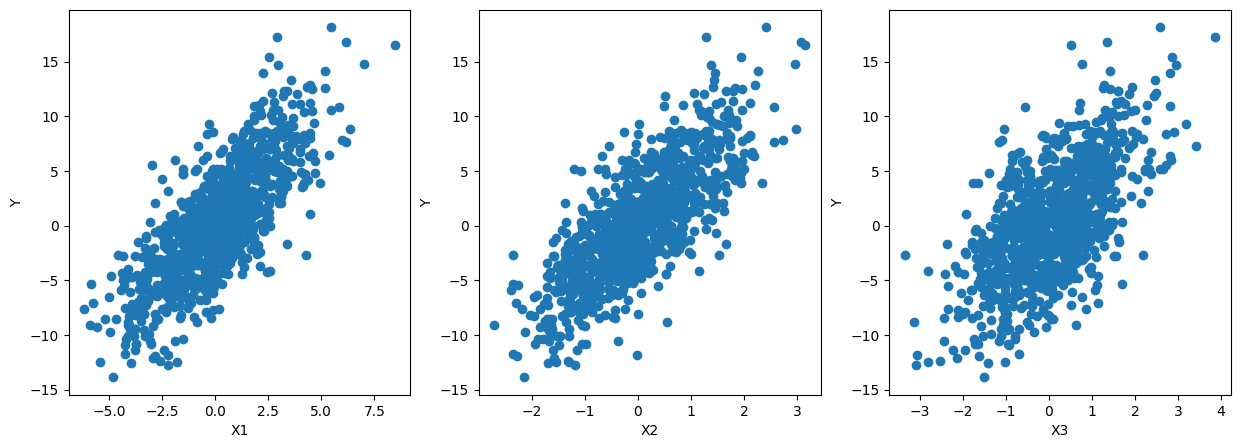

In [361]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5))
axs[0].scatter(data['X1'], y)
axs[0].set_xlabel('X1')
axs[0].set_ylabel('Y')

axs[1].scatter(data['X2'], y)
axs[1].set_xlabel('X2')
axs[1].set_ylabel('Y')

axs[2].scatter(data['X3'], y)
axs[2].set_xlabel('X3')
axs[2].set_ylabel('Y')

In [362]:
coef_single = {}
for col in ['X1','X2','X3']:
    m1 = LinearRegression().fit(data[[col]], y)
    coef_single[col] = m1.coef_[0]

In [363]:
coef_single = pd.Series(coef_single)

In [364]:
diffs = (coef_single - coef_multi).abs()
print("Single regression coefficients:\n", coef_single)
print("\nMultiple regression coefficients:\n", coef_multi)
print("\nDifferences:\n", diffs)
print("\nLargest difference is for:", diffs.idxmax())

Single regression coefficients:
 X1    1.841761
X2    4.083613
X3    3.097041
dtype: float64

Multiple regression coefficients:
 X1    1.007138
X2    1.964569
X3    2.975489
dtype: float64

Differences:
 X1    0.834623
X2    2.119044
X3    0.121553
dtype: float64

Largest difference is for: X2


In [365]:
y_pred = model.predict(X)
residuals = y - y_pred
n, k = X.shape

sigma2 = np.sum(residuals**2) / (n - k - 1)

X_with_const = np.column_stack([np.ones(len(X)), X])
XtX_inv = np.linalg.inv(X_with_const.T @ X_with_const)
var_b = sigma2 * XtX_inv

se = np.sqrt(np.diag(var_b))[1:]  

t_stats = model.coef_ / se

print("Coefficients:", model.coef_)
print("Standard errors:", se)
print("t-stats:", t_stats)
print("Most significant is:", ['X1','X2','X3'][np.argmax(np.abs(t_stats))])

Coefficients: [1.00713766 1.96456859 2.97548854]
Standard errors: [0.01651478 0.03687031 0.01513125]
t-stats: [ 60.98401128  53.28321197 196.64523988]
Most significant is: X3


In [366]:
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)
print("MSE:", mse)
print("RMSE:", rmse)
print("R^2:", r2)

MSE: 0.2509162964680301
RMSE: 0.5009154584039408
R^2: 0.9907160704940021


For Question 4 and 5:


Use NearestNeighbors to match data based on variables Z, given the file homework_1.2.csv.
Pick the best match in X = 0 corresponding to each X = 1. Use the Z values to perform the match: a good match with X = 1 is the item whose Z value is closest to the given sample's Z value with X = 0. I suggest using sklearn's NearestNeighbors to do this, but there are many ways to do it.  

In [367]:
data2 = pd.read_csv("/workspaces/DX702-mod-6/homework_1.2.csv")


In [368]:
from sklearn.neighbors import NearestNeighbors   

In [369]:
treated = data2[data2['X'] == 1]
control = data2[data2['X'] == 0]
model = NearestNeighbors(n_neighbors = 1)
result = model.fit(control[["Z"]])



In [370]:
distances, indices = model.kneighbors(treated[["Z"]], n_neighbors=1)


In [371]:
matches = treated.copy()
matches["matched_control_index"] = control.iloc[indices.ravel()].index.values
matches["distance"] = distances.ravel()

print(matches.head())


   Unnamed: 0  X         Y         Z  matched_control_index  distance
1           1  1  1.215189  0.715189                     93  0.001138
5           5  1  1.145894  0.645894                     56  0.007214
6           6  1  0.937587  0.437587                     41  0.000555
7           7  1  1.391773  0.891773                     18  0.113616
8           8  1  1.463663  0.963663                     18  0.185506


In [372]:
farthest = matches["distance"].max()
print(farthest)


0.2102170871093757


What is the effect? (The difference between the average Y value for X = 0 values vs. the average Y value for X = 1, where the X = 0 sample has the best match for each X = 1 value). So we use the matched sample of X = 0 and the full sample of X = 1.

In [373]:
treated_mean = treated['Y'].mean()


In [374]:
matched_controls = control.loc[matches["matched_control_index"]]
control_mean = matched_controls['Y'].mean()


In [375]:
effect = treated_mean - control_mean
print("Effect:", effect)


Effect: 0.5433600651913855


For questions 6 and 7:



Use NearestNeighbors to match data based on variables Z, given the file homework_1.2.csv. 
Try approach B: Pick all of the matches in X = 0 that are within a distance 0.2 of each X = 1. Duplicates are okay, in case a given sample with X = 0 is a good match for multiple items with X = 1. 

In [376]:
matches = []
for t_idx, t_row in treated.iterrows():
    for c_idx, c_row in control.iterrows():
        dist = abs(t_row['Z'] - c_row['Z'])
        if dist <= 0.2:
            matches.append((t_idx, c_idx, dist))

matches = pd.DataFrame(matches, columns=['treated_idx','control_idx','distance'])
print(matches.head())

   treated_idx  control_idx  distance
0            1            0  0.166376
1            1            2  0.112426
2            1            3  0.170306
3            1           11  0.186294
4            1           12  0.147145


In [377]:
# Count how many times each control is used
counts = matches['control_idx'].value_counts()

# Duplicates = (count - 1) for each control used more than once
duplicates = (counts - 1).sum()

print("Number of duplicates:", duplicates)


Number of duplicates: 685


In [378]:
effects = []
for t_idx, group in matches.groupby("treated_idx"):
    y_t = data2.loc[t_idx, 'Y']
    y_c_mean = data2.loc[group['control_idx'], 'Y'].mean()
    effects.append(y_t - y_c_mean)

effect = sum(effects) / len(effects)
print("Effect:", effect)

Effect: 0.568851653388148
